## Sử dụng thuật toán DDPG và phiên bản khác của nó là TD3 cho bài toán Stock Trading ##

##1. **CÀI ĐẶT CÁC THƯ VIỆN CẦN THIẾT** ##



In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/AI-Project/src/DDPG

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/AI-Project/src/DDPG


In [ ]:
# ## install finrl library
!pip install wrds
!pip install swig
!pip install -q condacolab
import condacolab
condacolab.install()
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

✨🍰✨ Everything looks OK!
  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-hos6p56f
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-hos6p56f
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit 046bda4ea98903c41e6a90b4d998cbc871bb406b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-mez_c03d/elegantrl_7df6d26d1aa644888fb2624bea9679de
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-mez_c03d/elegantrl_7df6d26d1aa644888fb2624bea9679de
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit 5ef11a573caeb79d1498119777dfd36bf155e14b
  Preparing metadata (setup.py) ... done


In [ ]:
!pip install importlib

import importlib

packages = [
    "yfinance",
    "pandas",
    "numpy",
    "matplotlib",
    "stockstats",
    "gym",
    "stable-baselines3",
    "tensorflow",
    "pyfolio",
]

for package in packages:
    try:
        importlib.import_module(package)
    except ImportError:
        print(f"Installing {package}...")
        !pip install {package}  # Using ! for shell command within the notebook
    else:
        print(f"{package} is already installed.")

print("All required packages are installed!")


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
yfinance is already installed.
pandas is already installed.
numpy is already installed.
matplotlib is already installed.
stockstats is already installed.
gym is already installed.
Installing stable-baselines3...
tensorflow is already installed.


/usr/local/lib/python3.10/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


pyfolio is already installed.
All required packages are installed!


In [34]:
# Import Packages

import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
from copy import deepcopy

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from stable_baselines3.common.logger import configure
from DDPGAgent import DDPGAgent #import module DDPGAgent
from Model import DDPG, TD3

from pprint import pprint

# iDDPGAgent
# sys.path.append("../FinRL-Library")

import itertools

In [ ]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [ ]:
print(DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


## 2.**Download data bằng Yahoo Downloader** ##

In [ ]:
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.config_tickers import DOW_30_TICKER

In [ ]:
df = YahooDownloader(start_date=TRAIN_START_DATE,
                    end_date= TRADE_END_DATE,
                    ticker_list = DOW_30_TICKER ).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Shape of DataFrame:  (58421, 8)


In [ ]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2014-01-06,19.194643,19.528570,19.057142,17.008963,412610800,AAPL,0
1,2014-01-06,114.470001,114.919998,113.120003,85.569206,2838100,AMGN,0
2,2014-01-06,89.699997,90.250000,89.379997,77.050133,2844700,AXP,0
3,2014-01-06,139.399994,139.759995,137.800003,118.295097,4196500,BA,0
4,2014-01-06,90.190002,90.300003,88.379997,66.633011,5233900,CAT,0


In [ ]:
df.tail()

,date,open,high,low,close,volume,tic,day
58416,2021-11-30,447.059998,451.350006,441.250000,427.189453,7435400,UNH,1
58417,2021-11-30,195.270004,197.660004,192.559998,190.093155,16023000,V,1
58418,2021-11-30,51.259998,51.360001,50.040001,42.967808,47766200,VZ,1
58419,2021-11-30,46.060001,46.509998,44.410000,38.954273,13238100,WBA,1
58420,2021-11-30,47.160000,47.500000,46.669998,44.966221,64818900,WMT,1


In [ ]:
df.shape

(58421, 8)

In [ ]:
df.sort_values(['date','tic']).head()

,date,open,high,low,close,volume,tic,day
0,2014-01-06,19.194643,19.528570,19.057142,17.008963,412610800,AAPL,0
1,2014-01-06,114.470001,114.919998,113.120003,85.569206,2838100,AMGN,0
2,2014-01-06,89.699997,90.250000,89.379997,77.050133,2844700,AXP,0
3,2014-01-06,139.399994,139.759995,137.800003,118.295097,4196500,BA,0
4,2014-01-06,90.190002,90.300003,88.379997,66.633011,5233900,CAT,0


In [ ]:
print(f"Unique stock: {len(df['tic'].unique())}")

Unique stock: 30


In [ ]:
df['tic'].value_counts()

tic
AAPL    1991
AMGN    1991
WMT     1991
WBA     1991
VZ      1991
V       1991
UNH     1991
TRV     1991
PG      1991
NKE     1991
MSFT    1991
MRK     1991
MMM     1991
MCD     1991
KO      1991
JPM     1991
JNJ     1991
INTC    1991
IBM     1991
HON     1991
HD      1991
GS      1991
DIS     1991
CVX     1991
CSCO    1991
CRM     1991
CAT     1991
BA      1991
AXP     1991
DOW      682
Name: count, dtype: int64

## 3.**Preprocess Data** ##

In [ ]:
INDICATORS = ['macd',
            'rsi_30',
            'cci_30',
            'dx_30']

In [ ]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

[*********************100%%**********************]  1 of 1 completed

Successfully added technical indicators
Shape of DataFrame:  (1990, 8)


Successfully added vix
Successfully added turbulence index


In [ ]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [ ]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,dx_30,vix,turbulence
0,2014-01-06,AAPL,19.194643,19.528570,19.057142,17.008963,412610800.0,0.0,0.0,0.0,66.666667,100.0,13.55,0.0
1,2014-01-06,AMGN,114.470001,114.919998,113.120003,85.569206,2838100.0,0.0,0.0,0.0,66.666667,100.0,13.55,0.0
2,2014-01-06,AXP,89.699997,90.250000,89.379997,77.050133,2844700.0,0.0,0.0,0.0,66.666667,100.0,13.55,0.0
3,2014-01-06,BA,139.399994,139.759995,137.800003,118.295097,4196500.0,0.0,0.0,0.0,66.666667,100.0,13.55,0.0
4,2014-01-06,CAT,90.190002,90.300003,88.379997,66.633011,5233900.0,0.0,0.0,0.0,66.666667,100.0,13.55,0.0
5,2014-01-06,CRM,55.200001,55.240002,54.029999,54.159252,2532700.0,0.0,0.0,0.0,66.666667,100.0,13.55,0.0
6,2014-01-06,CSCO,21.959999,22.230000,21.930000,15.971943,34150300.0,0.0,0.0,0.0,66.666667,100.0,13.55,0.0
7,2014-01-06,CVX,124.589996,124.800003,123.519997,80.629601,4252300.0,0.0,0.0,0.0,66.666667,100.0,13.55,0.0
8,2014-01-06,DIS,76.529999,76.839996,75.489998,69.551697,6816200.0,0.0,0.0,0.0,66.666667,100.0,13.55,0.0
9,2014-01-06,GS,179.149994,181.130005,178.880005,146.894363,2954000.0,0.0,0.0,0.0,66.666667,100.0,13.55,0.0


## 4.**Xây dựng môi trường theo style Gym của OpenAI** ##

In [ ]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

47966
580


In [ ]:
train.head()

,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,dx_30,vix,turbulence
0,2014-01-06,AAPL,19.194643,19.528570,19.057142,17.008963,412610800.0,0.0,0.0,0.0,66.666667,100.0,13.55,0.0
0,2014-01-06,AMGN,114.470001,114.919998,113.120003,85.569206,2838100.0,0.0,0.0,0.0,66.666667,100.0,13.55,0.0
0,2014-01-06,AXP,89.699997,90.250000,89.379997,77.050133,2844700.0,0.0,0.0,0.0,66.666667,100.0,13.55,0.0
0,2014-01-06,BA,139.399994,139.759995,137.800003,118.295097,4196500.0,0.0,0.0,0.0,66.666667,100.0,13.55,0.0
0,2014-01-06,CAT,90.190002,90.300003,88.379997,66.633011,5233900.0,0.0,0.0,0.0,66.666667,100.0,13.55,0.0


In [ ]:
train.tail()

,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,dx_30,vix,turbulence
1653,2020-07-30,UNH,301.679993,306.459991,298.890015,288.173767,2205300.0,3.0,2.155619,54.116516,64.681653,13.042588,24.76,28.413669
1653,2020-07-30,V,195.199997,196.559998,192.119995,188.645462,10499400.0,3.0,1.008868,51.568836,-12.424594,1.459306,24.76,28.413669
1653,2020-07-30,VZ,57.209999,57.459999,57.139999,46.359447,12635800.0,3.0,0.490274,55.706150,135.300112,26.455830,24.76,28.413669
1653,2020-07-30,WBA,40.549999,40.849998,39.990002,33.255165,4505600.0,3.0,-0.287819,47.451875,-54.942304,15.787239,24.76,28.413669
1653,2020-07-30,WMT,43.139999,43.473331,42.906666,40.801796,13788300.0,3.0,0.694471,56.720810,44.703981,28.086384,24.76,28.413669


In [ ]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,dx_30,vix,turbulence
0,2021-11-01,AAPL,148.990005,149.699997,147.800003,146.875198,74588300.0,0.0,1.276208,53.745428,83.740417,4.922968,16.41,21.717209
0,2021-11-01,AMGN,208.000000,212.089996,207.770004,193.405624,3105300.0,0.0,-1.597004,44.297381,0.915999,8.685633,16.41,21.717209
0,2021-11-01,AXP,174.580002,176.070007,173.339996,168.405426,2250400.0,0.0,1.873674,52.381501,-4.976394,3.946445,16.41,21.717209
0,2021-11-01,BA,207.000000,214.690002,206.809998,214.580002,9284900.0,0.0,-2.888246,46.938895,-80.065736,10.696893,16.41,21.717209
0,2021-11-01,CAT,204.289993,206.880005,203.809998,195.019897,3215200.0,0.0,1.387455,52.511567,146.260694,17.811531,16.41,21.717209


In [ ]:
trade.tail()

,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,dx_30,vix,turbulence
19,2021-11-29,UNH,443.559998,453.079987,440.549988,434.671173,4079700.0,0.0,2.356781,56.526691,-10.860308,1.377908,22.959999,69.574716
19,2021-11-29,V,201.000000,201.250000,195.360001,192.565369,14633500.0,0.0,-6.074550,38.844820,-120.293133,30.546549,22.959999,69.574716
19,2021-11-29,VZ,51.610001,51.849998,51.330002,44.155884,18652500.0,0.0,-0.287297,43.477740,-97.569870,30.957856,22.959999,69.574716
19,2021-11-29,WBA,46.110001,46.509998,45.500000,40.067261,8875200.0,0.0,-0.365762,44.103932,-146.857769,16.932415,22.959999,69.574716
19,2021-11-29,WMT,48.333332,48.416668,47.410000,45.605721,33039600.0,0.0,-0.153555,46.205276,-99.957280,21.702833,22.959999,69.574716


In [ ]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 175


In [ ]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

e_train_gym = StockTradingEnv(df = train, **env_kwargs)

env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


## 6.**Train Agent** ##

In [ ]:
agent = DDPGAgent(env = env_train)
model_ddpg = agent.get_model(model_name="ddpg")
model_td3 = agent.get_model(model_name="td3")
# set up logger
tmp_path = RESULTS_DIR + "/agent"
new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# Set new logger
model_ddpg.set_logger(new_logger_ddpg)

MODEL_KWARGS None
{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device
MODEL_KWARGS None
{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to results/agent


In [30]:
trained_ddpg = agent.train_model(model=model_ddpg,
                              tb_log_name='ddpg',
                              total_timesteps=20000)


day: 1653, episode: 30
begin_total_asset: 1000000.00
end_total_asset: 2388648.57
total_reward: 1388648.57
total_cost: 999.00
total_trades: 19836
Sharpe: 0.841
-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 23         |
|    time_elapsed    | 278        |
|    total_timesteps | 6616       |
| train/             |            |
|    actor_loss      | -13.8      |
|    critic_loss     | 0.64       |
|    learning_rate   | 0.001      |
|    n_updates       | 26415      |
|    reward          | -0.5482966 |
-----------------------------------
-----------------------------------
| time/              |            |
|    episodes        | 8          |
|    fps             | 22         |
|    time_elapsed    | 580        |
|    total_timesteps | 13232      |
| train/             |            |
|    actor_loss      | -12.4      |
|    critic_loss     | 0.529      |
|    learning_rate   | 0.001      |
|    n_update

In [28]:

trained_td3 = agent.train_model(model=model_td3,
                              tb_log_name='td3',
                              total_timesteps=20000)

-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 27         |
|    time_elapsed    | 237        |
|    total_timesteps | 6616       |
| train/             |            |
|    actor_loss      | -54.3      |
|    critic_loss     | 123        |
|    learning_rate   | 0.001      |
|    n_updates       | 6515       |
|    reward          | -2.9804254 |
-----------------------------------
day: 1653, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 2261675.61
total_reward: 1261675.61
total_cost: 998.99
total_trades: 18183
Sharpe: 0.720
-----------------------------------
| time/              |            |
|    episodes        | 8          |
|    fps             | 26         |
|    time_elapsed    | 492        |
|    total_timesteps | 13232      |
| train/             |            |
|    actor_loss      | -12.8      |
|    critic_loss     | 37.4       |
|    learning_rate   | 0.001      |
|    n_update

In [29]:
trained_ddpg.save(TRAINED_MODEL_DIR + "/agent_ddpg")
trained_td3.save(TRAINED_MODEL_DIR + "/agent_td3")

## 7.**Test Agent** ##

In [31]:
e_test_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [35]:
trained_ddpg = DDPG.load(TRAINED_MODEL_DIR + "/agent_ddpg")
trained_td3 = TD3.load(TRAINED_MODEL_DIR + "/agent_td3")

In [36]:
train_model = trained_ddpg
df_account_value_ddpg, df_actions_ddpg = agent.DRL_prediction(
    model=train_model,
    environment = e_test_gym)

hit end!


In [37]:
train_model = trained_td3
df_account_value_td3, df_actions_td3 = agent.DRL_prediction(
    model=train_model,
    environment = e_test_gym)

hit end!


In [38]:
def plot_account_value(data, title):
    """
    Plot the account value over time for the DDPG algorithm.

    Parameters:
    data (pd.DataFrame): DataFrame containing the date and account value.
    """
    # Ensure the 'date' column is in datetime format
    data['date'] = pd.to_datetime(data['date'])

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(data['date'], data['account_value'], marker='o', linestyle='-')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Account Value')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


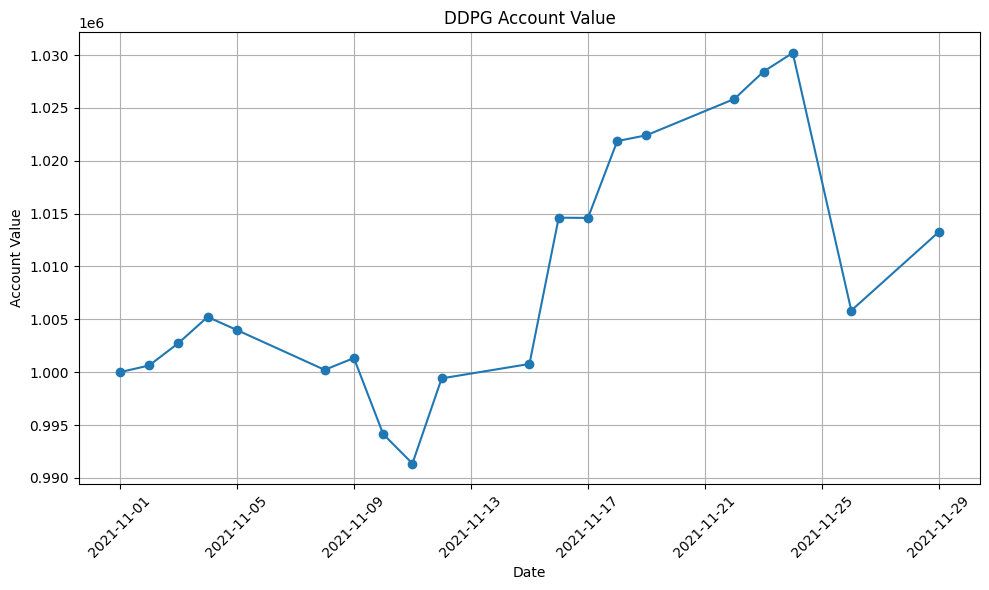

In [39]:
%matplotlib inline
plot_account_value(df_account_value_ddpg, "DDPG Account Value")

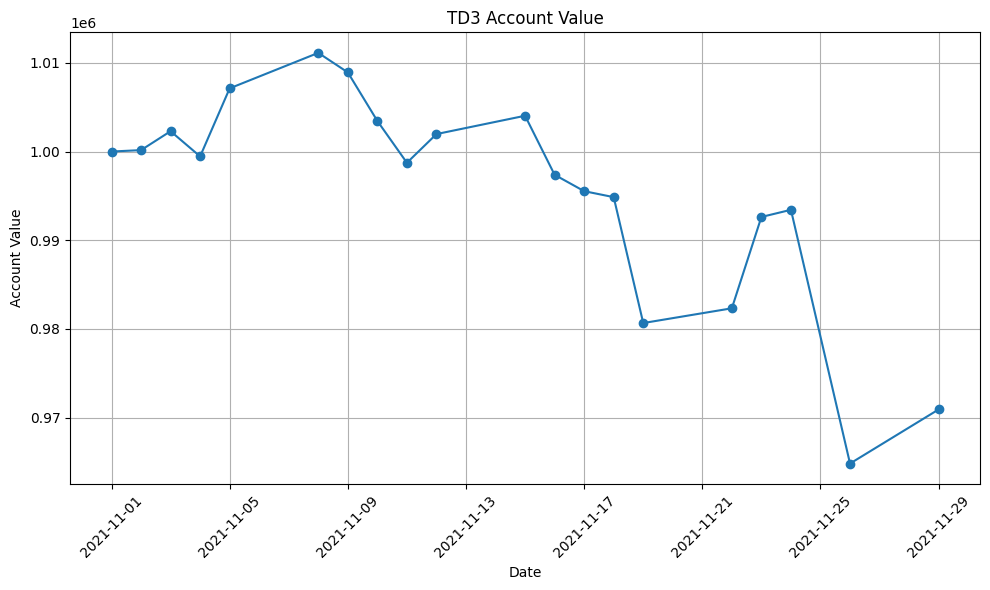

In [40]:
%matplotlib inline
plot_account_value(df_account_value_td3, "TD3 Account Value")

In [50]:
def compare_backtest_plot(
    ddpg_account_value,
    td3_account_value,
    value_col_name="account_value",
    date_col_name="date",
    xlabel="Date",
    ylabel="Account Value",
    num_days_xticks=20,
    xrotation=45,
):
    # Create copies of the dataframes to avoid modifying the original data
    ddpg_df = deepcopy(ddpg_account_value)
    td3_df = deepcopy(td3_account_value)

    # Ensure the date column is in datetime format
    ddpg_df[date_col_name] = pd.to_datetime(ddpg_df[date_col_name])
    td3_df[date_col_name] = pd.to_datetime(td3_df[date_col_name])

    # Merge the two dataframes on the date column
    merged_df = pd.merge(ddpg_df[[date_col_name, value_col_name]],
                         td3_df[[date_col_name, value_col_name]],
                         on=date_col_name,
                         how='inner',
                         suffixes=('_ddpg', '_td3'))

    # Plot the account values
    plt.figure(figsize=(15, 6))
    plt.plot(merged_df[date_col_name], merged_df[f"{value_col_name}_ddpg"], label="DDPG", color='blue')
    plt.plot(merged_df[date_col_name], merged_df[f"{value_col_name}_td3"], label="TD3", color='green')

    # Set plot title and labels
    plt.title("DDPG vs TD3 Account Values", fontsize=20)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)

    # Set x-ticks
    plt.xticks(size=12, rotation=xrotation)
    plt.yticks(size=12)
    plt.xticks(merged_df[date_col_name][::num_days_xticks])

    # Add grid, legend, and layout adjustments
    plt.grid()
    plt.legend(fontsize=15)
    plt.tight_layout()

    plt.show()


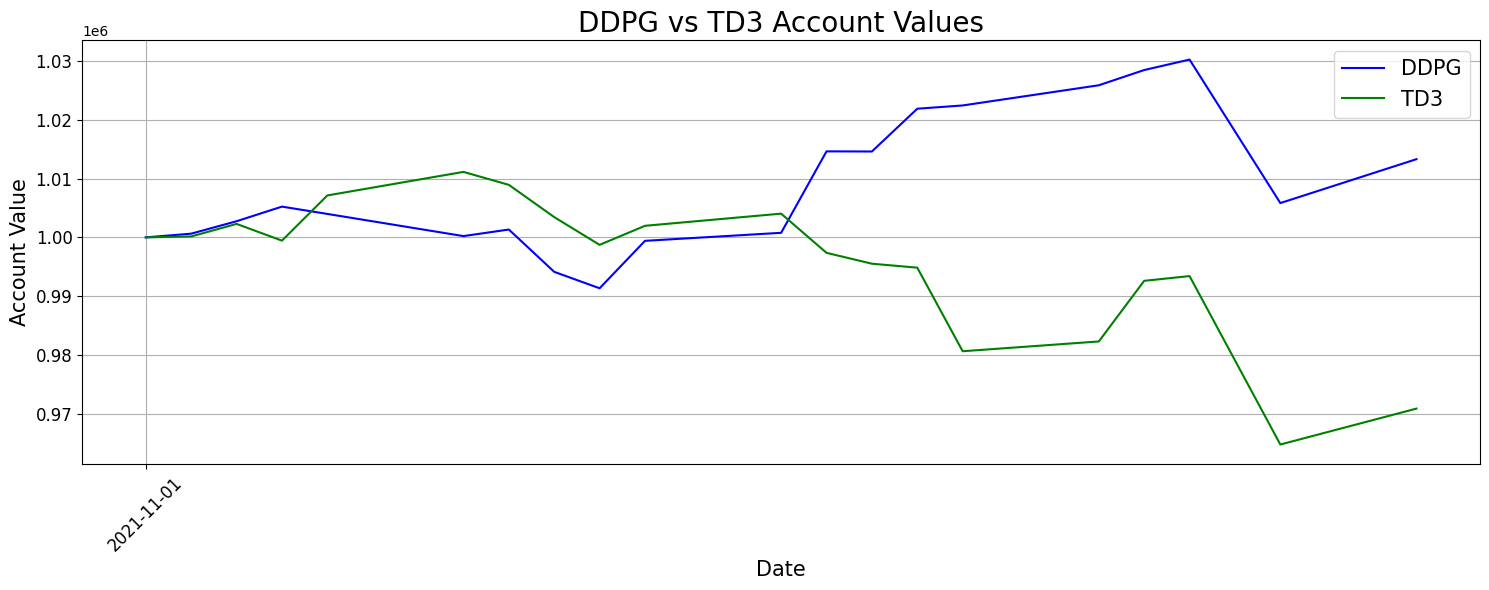

In [51]:
compare_backtest_plot(df_account_value_ddpg, df_account_value_td3)